# loading Data

In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
from utils import *

In [2]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [3]:
print("Number of images: {}".format(key_pts_frame.shape[0]))

Number of images: 3462


### show some images with the key points

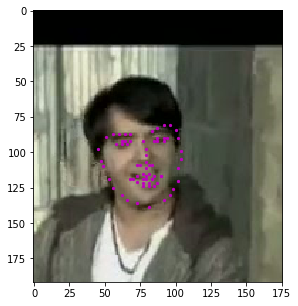

In [4]:
n = 0
img_name = key_pts_frame.iloc[n, 0]
kpts = key_pts_frame.iloc[n, 1:].values
kpts = kpts.astype("float32").reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_kpts(mpimg.imread(os.path.join('data/training/', image_name)), kpts)
plt.show()

## Preprocessing the data
normalizing the pixle data of the images is very easy and straight forward, however, there are two ways to normalize the output vector of key points
- normalizing grouping by element

   calculate the mean and standard deviation of each element in the vector and for each element subtract the mean and devide by the standard deviation
you'll need to save the mean and std vectors for using after prediction

- normalizing using a scaler value for all points

   calculate the mean and standard deviation of all points and use those to normalize the data
    
    
to me the first method makes more sence, however, the second one shows better results, let's try both

### Normalization grouping by element

In [13]:
# calculate mean and std over the first axis
# this will give a vector of shape (136,)
grand_mean = key_pts_frame.iloc[:, 1:].values.mean(axis=0)
grand_std = key_pts_frame.iloc[:, 1:].values.std(axis=0)

# validate that the shape is correct
print(grand_mean.shape, grand_std.shape)

# grand_mean = key_pts_frame.iloc[:, 1:].values.mean()
# grand_std = key_pts_frame.iloc[:, 1:].values.std()
# print(grand_mean, grand_std)

(136,) (136,)


In [6]:
# save the vectors for later
np.save("data/grand_mean.npy", grand_mean)
np.save("data/grand_std.npy", grand_std)

### Create The Dataset

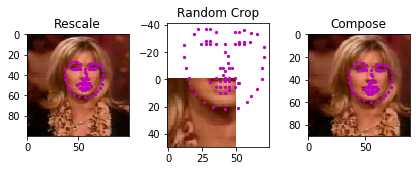

In [7]:
# first of all let's test the utility functions that we've imported from util file

# choose an image
n = 500
img_name = key_pts_frame.iloc[n, 0]
kpts = key_pts_frame.iloc[n, 1:].values
kpts = kpts.astype("float32").reshape(-1, 2)
img = mpimg.imread(os.path.join('data/training/', img_name))
sample = {"image": img, "keypoints": kpts}

# rescale and plot
fig = plt.figure()
transformed_sample = rescale(sample, (100, 100))
ax = plt.subplot(1, 3, 1)
plt.tight_layout()
ax.set_title("Rescale")
show_kpts(transformed_sample['image'], transformed_sample['keypoints'])

# crop and plot
transformed_sample = randomCrop(sample, (50, 50))
ax = plt.subplot(1, 3, 2)
plt.tight_layout()
ax.set_title("Random Crop")
show_kpts(transformed_sample['image'], transformed_sample['keypoints'])

# rescale, crop, and plot
transformed_sample = rescale(sample, (100, 100))
transformed_sample = randomCrop(transformed_sample, (90, 90))
ax = plt.subplot(1, 3, 3)
plt.tight_layout()
ax.set_title("Compose")
show_kpts(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [14]:
# now let's create the dataset
# the following is going to use key_pts_frame dataframe
# it will use grand_mean and grand_std to normalize the keypoints
# it will rescale the images to be 100 x 100
# it will crop the images to be 90 x 90
# will reaturn two arrays X and y
X, y = create_data_set(key_pts_frame, grand_mean, grand_std, (100, 100), (90, 90))
print(X.shape, y.shape)

100%|██████████| 3462/3462 [01:08<00:00, 50.88it/s]


(3462, 90, 90) (3462, 136, 1)


The shapes are looking good, looks like the images are croped and the outputs are as expected

Now let's save the data to disk

In [15]:
np.save("data/features_vector_normalized.npy", X)
np.save("data/labels_vector_normalized.npy", y)

### Normalizing using constant scaler values

In [10]:
# let's calculate the mean and standard deviation on the entire thing now
grand_mean = key_pts_frame.iloc[:, 1:].values.mean()
grand_std = key_pts_frame.iloc[:, 1:].values.std()
print(grand_mean, grand_std)

104.4724870017331 43.173022717543226


In [11]:
# now let's create a new dataset
X, y = create_data_set(key_pts_frame, grand_mean, grand_std, (100, 100), (90, 90))
print(X.shape, y.shape)

100%|██████████| 3462/3462 [01:01<00:00, 56.04it/s]


(3462, 90, 90) (3462, 136, 1)


In [12]:
# looking good, now let's save those as well
np.save("data/features_scaler_normalized.npy", X)
np.save("data/labels_scaler_normalized.npy", y)

Now let's load those files and plot some of the images

In [22]:
X = np.load("data/features_vector_normalized.npy")
y = np.load("data/labels_vector_normalized.npy")

grand_mean = np.load("data/grand_mean.npy").reshape(-1, 1) # this reshape is important
grand_std = np.load("data/grand_std.npy").reshape(-1, 1) # guess what, so is this one

(136, 1) (136, 1) (136, 1)


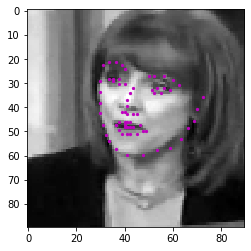

In [24]:
n = 2

kpts = y[n] * grand_std + grand_mean
show_kpts(X[n], kpts.reshape(-1, 2), cmap="gray")

Now let's get the constant normalized data

In [26]:
X = np.load("data/features_scaler_normalized.npy")
y = np.load("data/labels_scaler_normalized.npy")

# we've calculated these before
grand_mean = 104.47
grand_std = 43.17

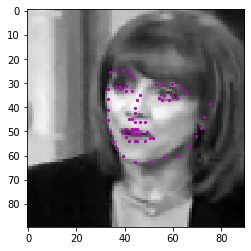

In [27]:
kpts = y[n] * grand_std + grand_mean
show_kpts(X[n], kpts.reshape(-1, 2), cmap="gray")

## Looking good!

### In the next notebook we will create and train the model.

## Creating the model

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout

In [ ]:
model = Sequential([
    Conv2D(32, (5, 5), activation="elu", input_shape=[90, 90, 1]),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.2),
    
    Conv2D(32, (5, 5), activation="elu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(64, (5, 5), activation="elu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(128, (5, 5), activation="elu"),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(256, (5, 5), activation="elu"),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(512, (5, 5), activation="elu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Flatten(),

    Dense(2048, activation="elu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1024, activation="elu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(136)
])

In [ ]:
tf.keras.backend.clear_session()
model.compile(
    loss=tf.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(0.005),
    metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
history = model.fit(X, y, validation_split=0.2, epochs=150)

In [ ]:
img = mpimg.imread(os.path.join('drive/My Drive/', 'test2.jpg'))
sample = rescale({"image": img, "keypoints": None}, (100, 100))
sample = randomCrop(sample, (90, 90))
sample = normalize(sample)
# img = X[0].reshape(90, 90)

kpts = model.predict(img.reshape(1, 90, 90, 1))
show_kpts(img, kpts[0].reshape(-1, 2) * 50 + 100, cmap="gray")